# TimesNet Training on ETT Datasets

This notebook trains TimesNet on all 4 ETT datasets (ETTh1, ETTh2, ETTm1, ETTm2) with different prediction horizons.

**Datasets:**
- ETTh1, ETTh2: Hourly data
- ETTm1, ETTm2: 15-minute data

**Configuration:**
- Input length: 96 (fixed, as in paper)
- Prediction horizons: {24, 48, 96, 192, 336, 720}
- Total experiments: 4 datasets × 6 horizons = 24 models

## Setup

In [1]:
!git clone https://github.com/ltruciosr-dev/timesnet-ett

# Change to the cloned repository directory
%cd timesnet-ett

Cloning into 'timesnet-ett'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 40 (delta 13), reused 28 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 4.96 MiB | 24.18 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/timesnet-ett


In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Add src to path
sys.path.append('./src')

from src.train import TimesNetTrainer
from src.evaluate import (
    evaluate_and_save_results,
    plot_training_curves,
    visualize_horizon_predictions,
    plot_comprehensive_training_summary
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports successful")

✓ Imports successful


## Configuration

In [3]:
# Base paths
ROOT_PATH = './ETDataset/ETT-small/'
CHECKPOINT_BASE = './checkpoints'
RESULTS_DIR = './results'

# Create directories
os.makedirs(CHECKPOINT_BASE, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Datasets
DATASETS = ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2']

# Fixed input length (as in paper)
SEQ_LEN = 96

# Prediction horizons
PRED_LENS = [24, 48, 96, 192, 336, 720]

# Model hyperparameters (from paper)
MODEL_CONFIGS = {
    'ETTh1': {'d_model': 16, 'd_ff': 32},
    'ETTh2': {'d_model': 16, 'd_ff': 32},
    'ETTm1': {'d_model': 32, 'd_ff': 64},
    'ETTm2': {'d_model': 32, 'd_ff': 64},
}

# Training config
TRAIN_CONFIG = {
    'enc_in': 7,
    'c_out': 7,
    'top_k': 5,
    'e_layers': 2,
    'num_kernels': 6,
    'dropout': 0.1,
    'embed': 'fixed',
    'batch_size': 32,
    'learning_rate': 0.0001,
    'train_epochs': 10,
    'patience': 3,
    'lradj': 'type1',
    'use_amp': False,
    'num_workers': 0,
}

print(f"✓ Configuration set")
print(f"  - Datasets: {DATASETS}")
print(f"  - Input length: {SEQ_LEN}")
print(f"  - Prediction horizons: {PRED_LENS}")
print(f"  - Total experiments: {len(DATASETS) * len(PRED_LENS)}")

✓ Configuration set
  - Datasets: ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2']
  - Input length: 96
  - Prediction horizons: [24, 48, 96, 192, 336, 720]
  - Total experiments: 24


## Training Function

In [4]:
def train_single_model(dataset_name, pred_len):
    """
    Train a single TimesNet model with comprehensive visualizations

    Args:
        dataset_name: Dataset name (e.g., 'ETTh1')
        pred_len: Prediction horizon

    Returns:
        dict: Training results
    """
    print("\n" + "="*70)
    print(f"Training: {dataset_name} | seq_len={SEQ_LEN} → pred_len={pred_len}")
    print("="*70)

    # Create config
    config = {
        'root_path': ROOT_PATH,
        'data_path': f'{dataset_name}.csv',
        'seq_len': SEQ_LEN,
        'pred_len': pred_len,
        'checkpoints': f'{CHECKPOINT_BASE}/{dataset_name}_{SEQ_LEN}_{pred_len}',
        **TRAIN_CONFIG,
        **MODEL_CONFIGS[dataset_name]
    }

    # Create checkpoint directory
    os.makedirs(config['checkpoints'], exist_ok=True)

    # Train
    trainer = TimesNetTrainer(config)
    train_losses, val_losses = trainer.train()

    # Test
    test_results = trainer.test()

    # ========== ENHANCED VISUALIZATIONS ==========

    print("\n📊 Creating visualizations...")

    # 1. Horizon predictions (input context + forecast)
    print("  → Horizon predictions (train/val/test samples)...")
    visualize_horizon_predictions(
        model=trainer.model,
        train_loader=trainer.train_loader,
        val_loader=trainer.val_loader,
        test_loader=trainer.test_loader,
        device=trainer.device,
        scaler=trainer.train_dataset.scaler,
        seq_len=config['seq_len'],
        pred_len=config['pred_len'],
        num_samples=3,
        feature_idx=0,
        feature_name='OT',
        save_path=f'{RESULTS_DIR}/{dataset_name}_{SEQ_LEN}_{pred_len}_horizons.png'
    )

    # 2. Comprehensive training summary (4-panel plot)
    print("  → Comprehensive training summary...")
    plot_comprehensive_training_summary(
        train_losses=train_losses,
        val_losses=val_losses,
        test_results=test_results,
        dataset_name=dataset_name,
        seq_len=config['seq_len'],
        pred_len=config['pred_len'],
        save_path=f'{RESULTS_DIR}/{dataset_name}_{SEQ_LEN}_{pred_len}_summary.png'
    )

    # 3. Evaluate on all splits
    print("  → Evaluating all splits (train/val/test)...")
    all_split_results = evaluate_and_save_results(
        model=trainer.model,
        train_loader=trainer.train_loader,
        val_loader=trainer.val_loader,
        test_loader=trainer.test_loader,
        device=trainer.device,
        scaler=trainer.train_dataset.scaler,
        save_path=f'{RESULTS_DIR}/{dataset_name}_{SEQ_LEN}_{pred_len}_all_metrics.txt'
    )

    # Prepare results
    results = {
        'dataset': dataset_name,
        'seq_len': SEQ_LEN,
        'pred_len': pred_len,
        'd_model': config['d_model'],
        'd_ff': config['d_ff'],
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_mse': test_results['mse'],
        'test_mae': test_results['mae'],
        'test_rmse': test_results['rmse'],
        'final_epoch': len(train_losses),
        # Add all split metrics
        'train_mse': all_split_results['train']['mse'],
        'train_mae': all_split_results['train']['mae'],
        'val_mse': all_split_results['val']['mse'],
        'val_mae': all_split_results['val']['mae'],
    }

    print(f"\n✓ Completed: {dataset_name}_{SEQ_LEN}_{pred_len}")
    print(f"  - Train MSE: {all_split_results['train']['mse']:.6f}")
    print(f"  - Val MSE:   {all_split_results['val']['mse']:.6f}")
    print(f"  - Test MSE:  {test_results['mse']:.6f}")
    print(f"  - Test MAE:  {test_results['mae']:.6f}")
    print(f"  - Test RMSE: {test_results['rmse']:.6f}")

    return results

## Train All Models

In [5]:
DATASETS = ['ETTm1'] # ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2']


######################################################################
# Experiment 1/6
######################################################################

Training: ETTm1 | seq_len=96 → pred_len=24
Using device: cuda
Initializing data loaders...
Train samples: 48657
Val samples: 6945
Test samples: 13913
Initializing model...
Model parameters: 2,356,671
Starting training...
	Iter: 100, Loss: 0.2741350
	Iter: 200, Loss: 0.3228466
	Iter: 300, Loss: 0.3007208
	Iter: 400, Loss: 0.2597360
	Iter: 500, Loss: 0.2283670
	Iter: 600, Loss: 0.2525384
	Iter: 700, Loss: 0.2394659
	Iter: 800, Loss: 0.1792110
	Iter: 900, Loss: 0.1576819
	Iter: 1000, Loss: 0.1601117
	Iter: 1100, Loss: 0.1873807
	Iter: 1200, Loss: 0.1777572
	Iter: 1300, Loss: 0.1602784
	Iter: 1400, Loss: 0.1883883
	Iter: 1500, Loss: 0.2081789
Epoch: 1 | Time: 68.12s
Train Loss: 0.2120617 | Val Loss: 0.2190849
Validation loss decreased (inf --> 0.219085). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.2016729


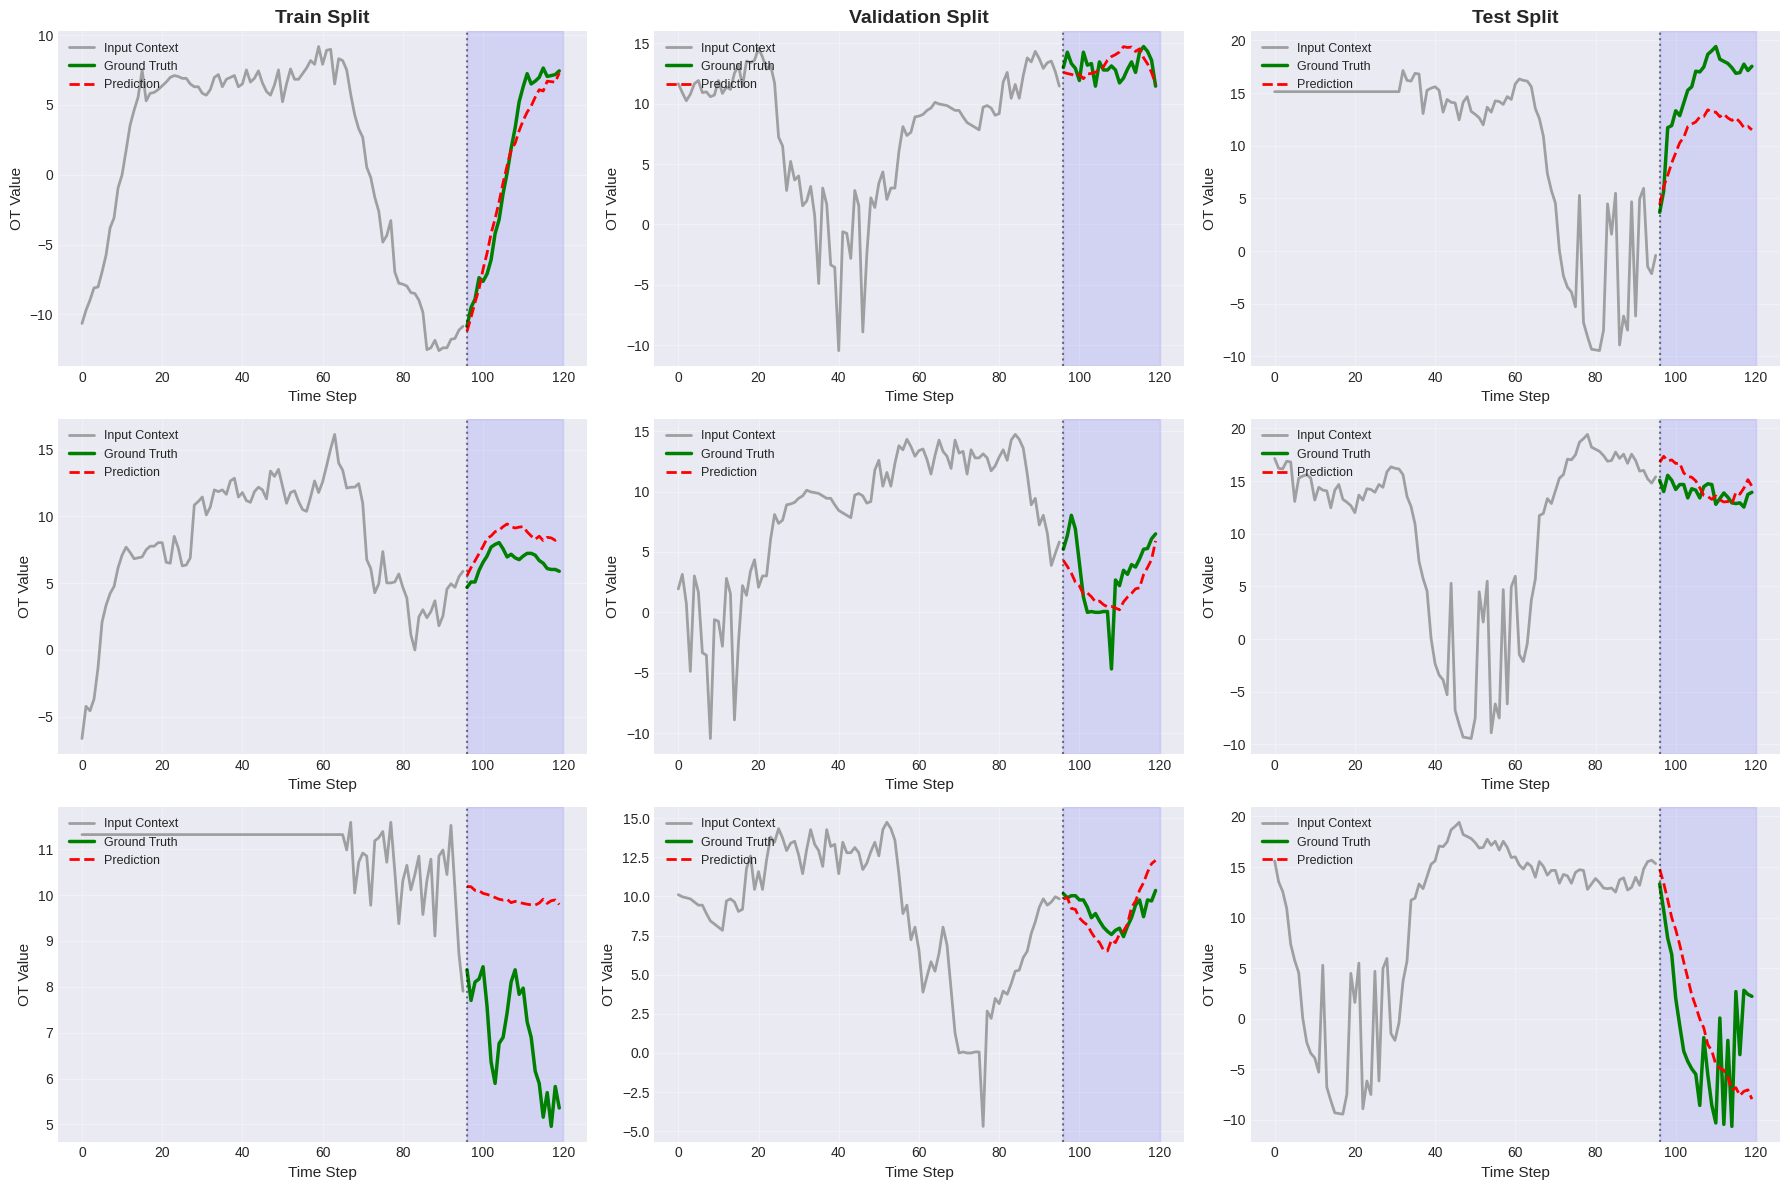

  → Comprehensive training summary...
Comprehensive training summary saved to ./results/ETTm1_96_24_summary.png


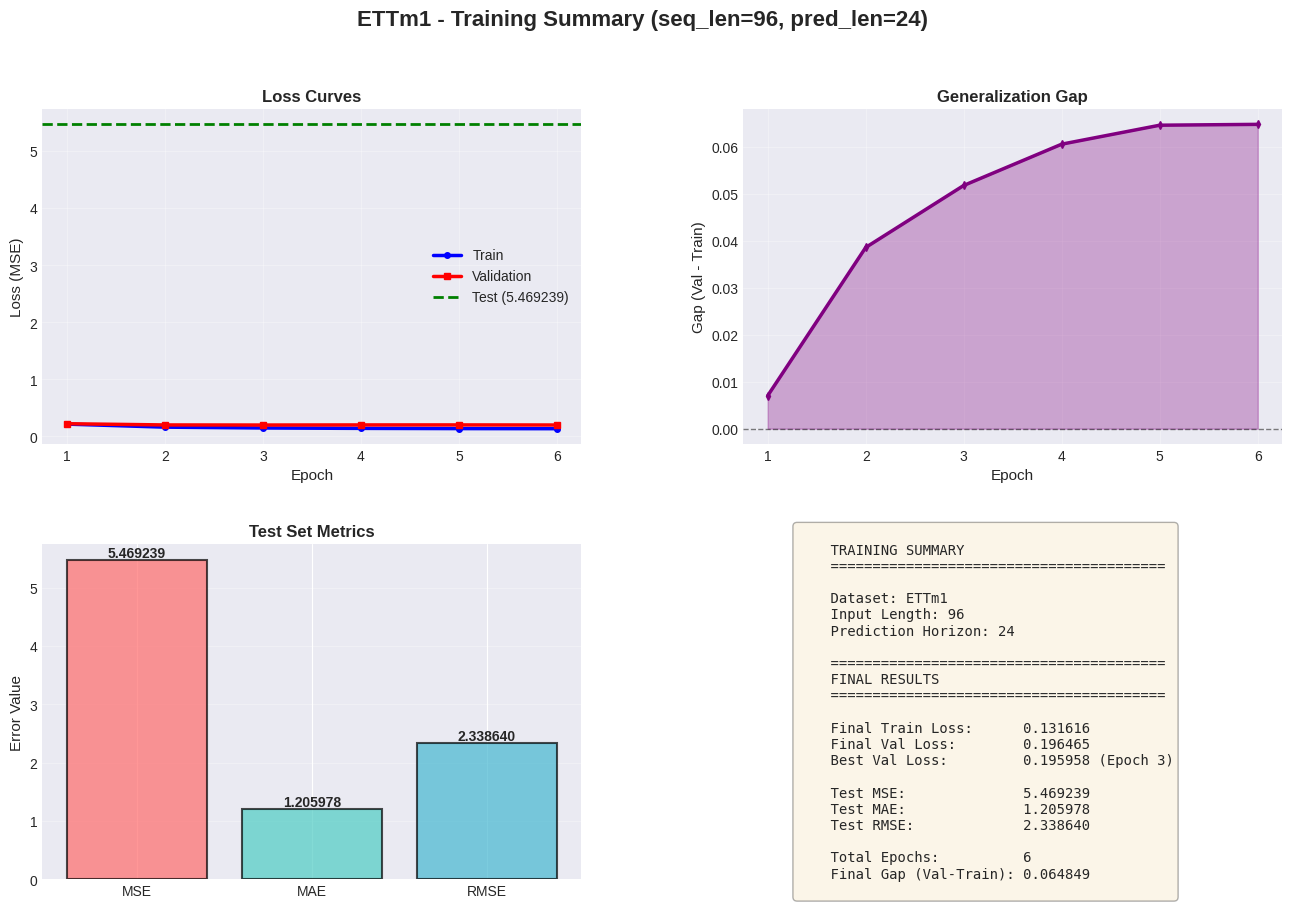

  → Evaluating all splits (train/val/test)...
Evaluating model on all splits...

Train Results:
  MSE: 2.5144842
  MAE: 0.8824740
  RMSE: 1.5857126
  MAPE: 972285.1875000
  MSPE: 1259313402216448.0000000

Validation Results:
  MSE: 4.0989194
  MAE: 0.9937373
  RMSE: 2.0245788
  MAPE: 232821.3437500
  MSPE: 276454361268224.0000000

Test Results:
  MSE: 5.4692392
  MAE: 1.2059783
  RMSE: 2.3386405
  MAPE: 298107.0312500
  MSPE: 487960831066112.0000000

❌ Error training ETTm1_96_24: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Experiment 2/6
######################################################################

Training: ETTm1 | seq_len=96 → pred_len=48
Using device: cuda
Initializing data loaders...


Traceback (most recent call last):
  File "/tmp/ipython-input-988559071.py", line 17, in <cell line: 0>
    results = train_single_model(dataset_name, pred_len)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1533522811.py", line 72, in train_single_model
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


Train samples: 48633
Val samples: 6921
Test samples: 13889
Initializing model...
Model parameters: 2,358,999
Starting training...
	Iter: 100, Loss: 0.3648998
	Iter: 200, Loss: 0.3593737
	Iter: 300, Loss: 0.2499722
	Iter: 400, Loss: 0.3402669
	Iter: 500, Loss: 0.2021828
	Iter: 600, Loss: 0.2358723
	Iter: 700, Loss: 0.2840561
	Iter: 800, Loss: 0.2083347
	Iter: 900, Loss: 0.1818694
	Iter: 1000, Loss: 0.1898501
	Iter: 1100, Loss: 0.1972644
	Iter: 1200, Loss: 0.2162549
	Iter: 1300, Loss: 0.2500725
	Iter: 1400, Loss: 0.1705880
	Iter: 1500, Loss: 0.2028033
Epoch: 1 | Time: 68.59s
Train Loss: 0.2612597 | Val Loss: 0.2513258
Validation loss decreased (inf --> 0.251326). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.2443978
	Iter: 200, Loss: 0.2280591
	Iter: 300, Loss: 0.2561685
	Iter: 400, Loss: 0.1685505
	Iter: 500, Loss: 0.1707865
	Iter: 600, Loss: 0.1751394
	Iter: 700, Loss: 0.1779906
	Iter: 800, Loss: 0.1527668
	Iter: 900, Loss: 0.1967194
	Iter: 1000, Loss: 0.1772334

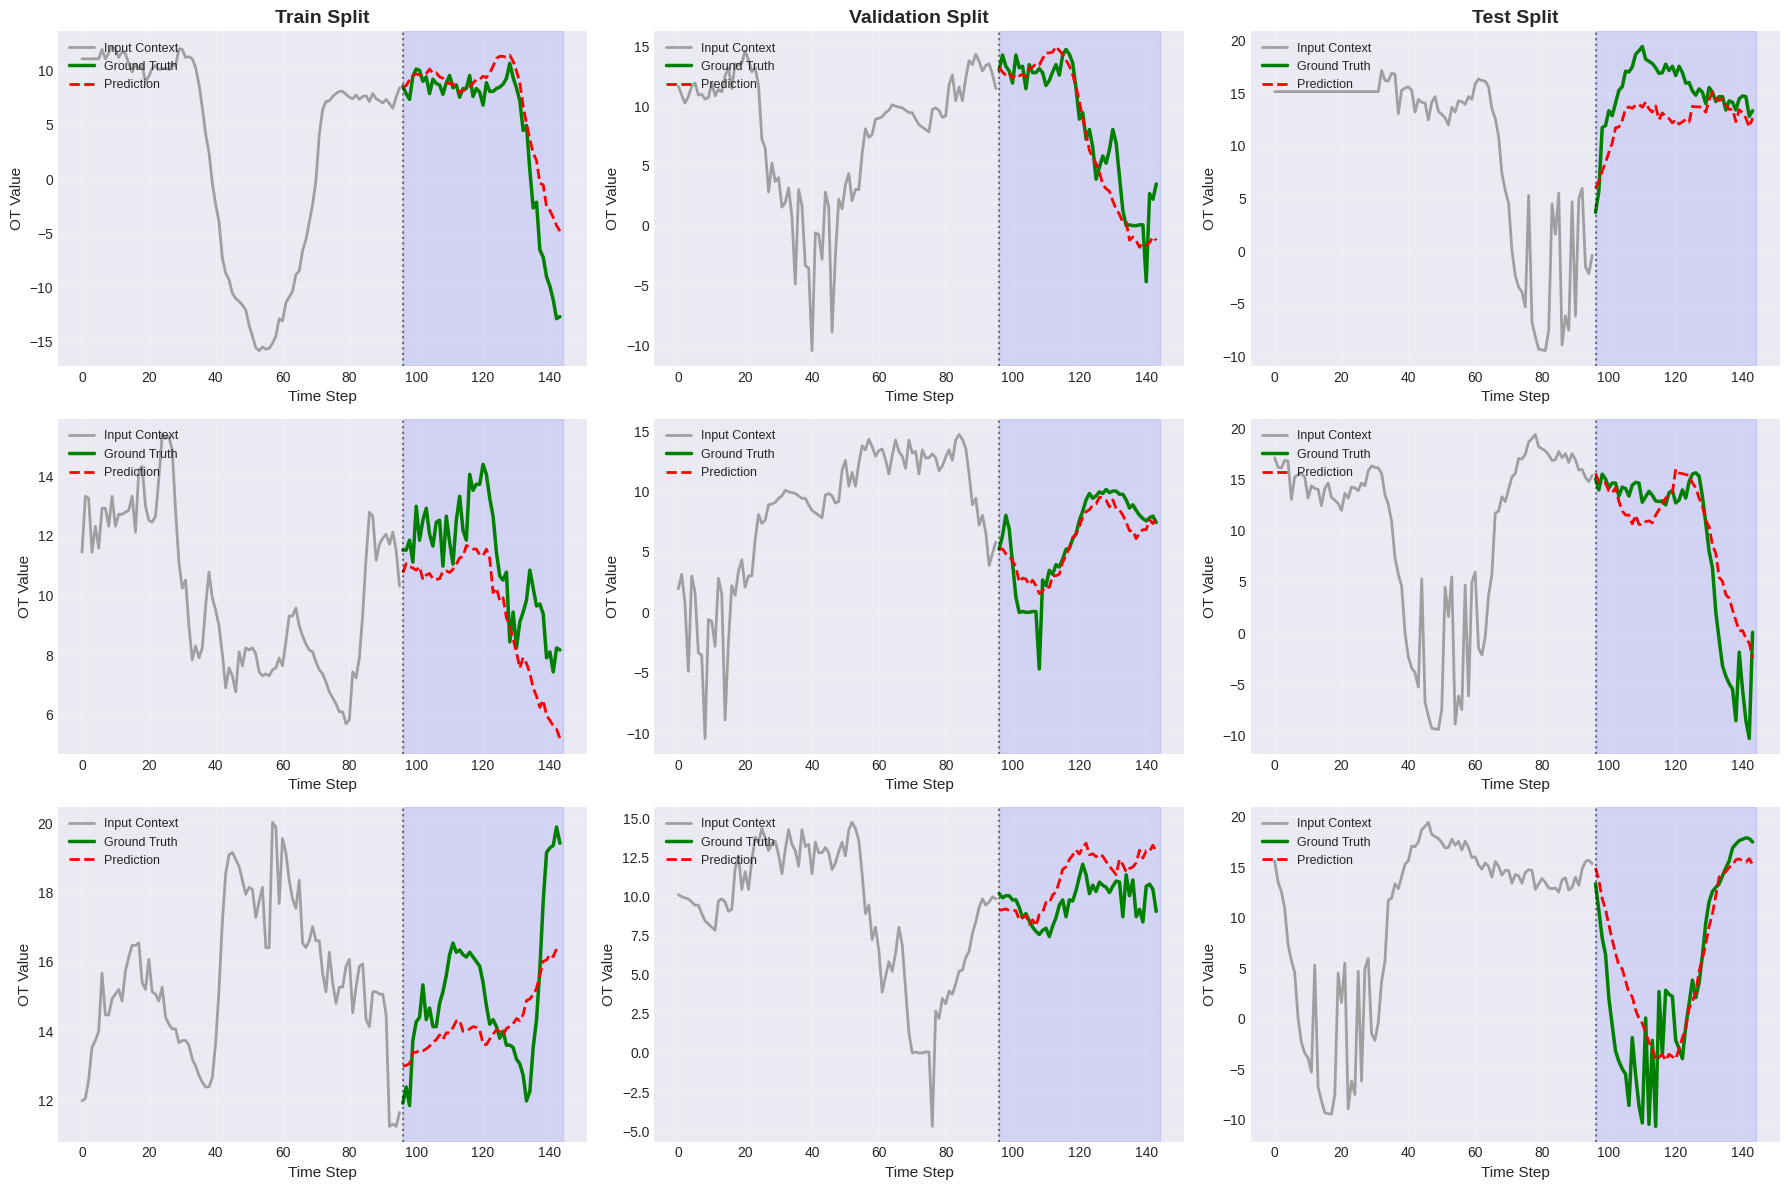

  → Comprehensive training summary...
Comprehensive training summary saved to ./results/ETTm1_96_48_summary.png


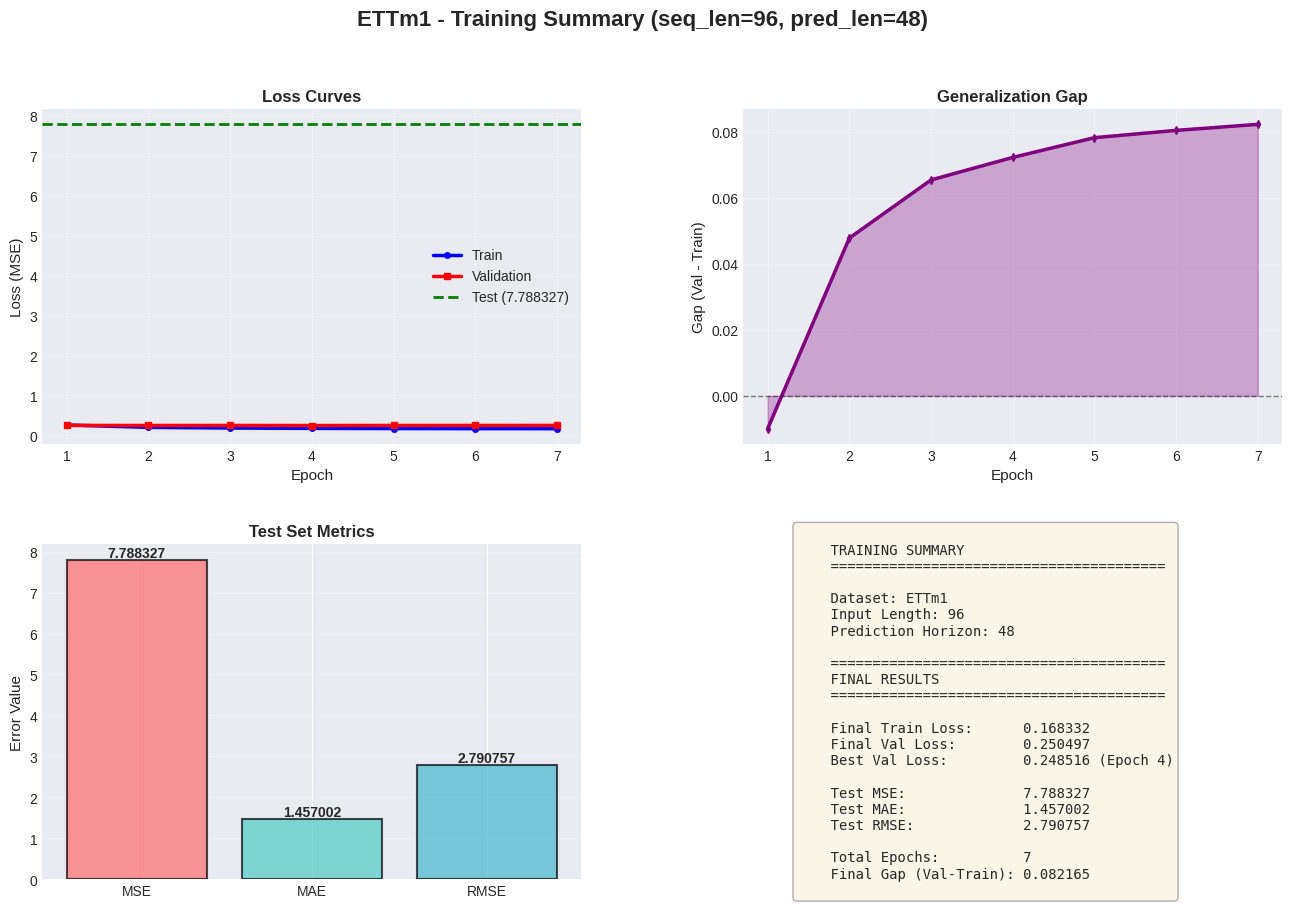

  → Evaluating all splits (train/val/test)...
Evaluating model on all splits...

Train Results:
  MSE: 3.2001870
  MAE: 1.0009445
  RMSE: 1.7889067
  MAPE: 1148691.8750000
  MSPE: 1561610380378112.0000000

Validation Results:
  MSE: 5.1738267
  MAE: 1.1373708
  RMSE: 2.2746048
  MAPE: 311246.5312500
  MSPE: 610722002239488.0000000

Test Results:
  MSE: 7.7883267
  MAE: 1.4570016
  RMSE: 2.7907574
  MAPE: 339974.5312500
  MSPE: 818356626128896.0000000

❌ Error training ETTm1_96_48: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Experiment 3/6
######################################################################

Training: ETTm1 | seq_len=96 → pred_len=96
Using device: cuda
Initializing data loaders...


Traceback (most recent call last):
  File "/tmp/ipython-input-988559071.py", line 17, in <cell line: 0>
    results = train_single_model(dataset_name, pred_len)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1533522811.py", line 72, in train_single_model
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


Train samples: 48585
Val samples: 6873
Test samples: 13841
Initializing model...
Model parameters: 2,363,655
Starting training...
	Iter: 100, Loss: 0.3520852
	Iter: 200, Loss: 0.3364981
	Iter: 300, Loss: 0.2805243
	Iter: 400, Loss: 0.2717710
	Iter: 500, Loss: 0.2473092
	Iter: 600, Loss: 0.2551326
	Iter: 700, Loss: 0.3086346
	Iter: 800, Loss: 0.2888054
	Iter: 900, Loss: 0.3187808
	Iter: 1000, Loss: 0.3018573
	Iter: 1100, Loss: 0.2316061
	Iter: 1200, Loss: 0.2807407
	Iter: 1300, Loss: 0.3199066
	Iter: 1400, Loss: 0.2509470
	Iter: 1500, Loss: 0.2246812
Epoch: 1 | Time: 89.67s
Train Loss: 0.2912434 | Val Loss: 0.2772012
Validation loss decreased (inf --> 0.277201). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.2557636
	Iter: 200, Loss: 0.2186613
	Iter: 300, Loss: 0.2790950
	Iter: 400, Loss: 0.2273367
	Iter: 500, Loss: 0.2126651
	Iter: 600, Loss: 0.2873897
	Iter: 700, Loss: 0.1947060
	Iter: 800, Loss: 0.2279566
	Iter: 900, Loss: 0.1861881
	Iter: 1000, Loss: 0.1782317

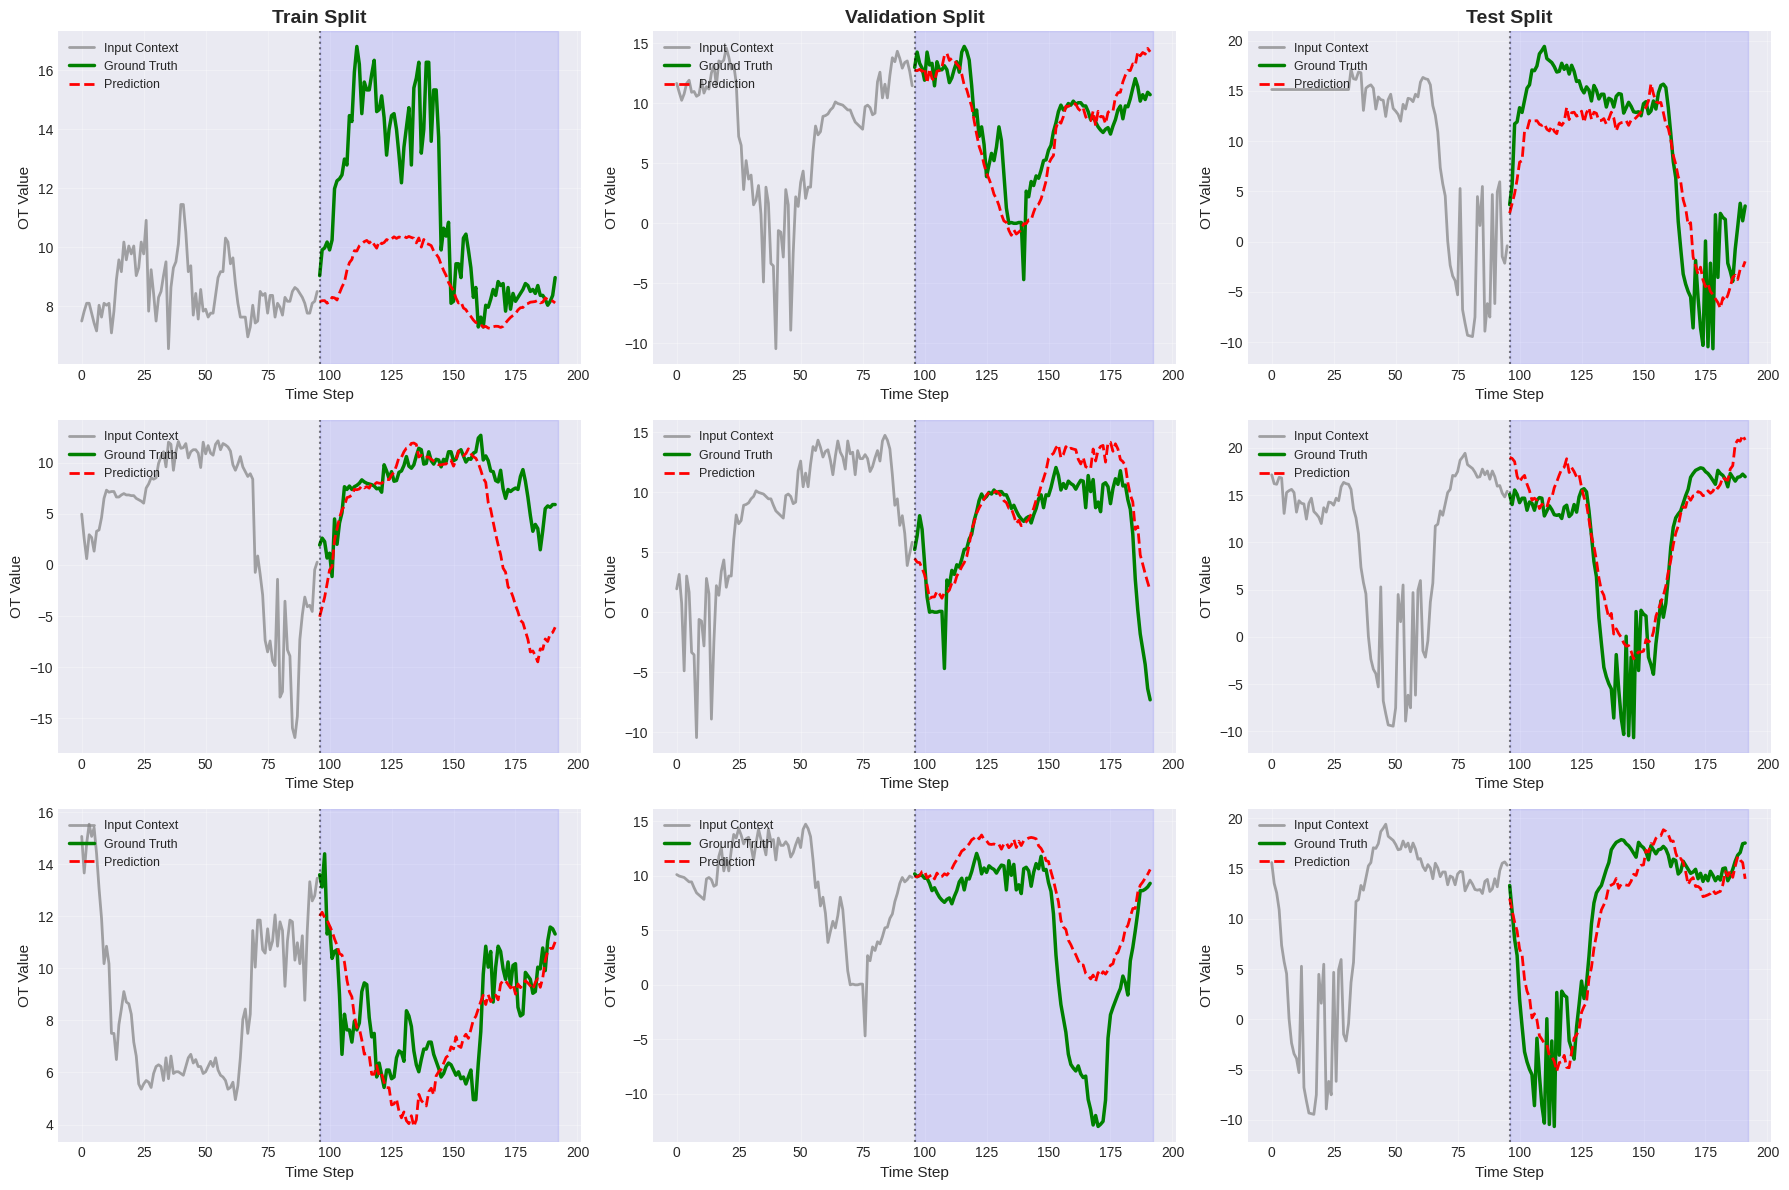

  → Comprehensive training summary...
Comprehensive training summary saved to ./results/ETTm1_96_96_summary.png


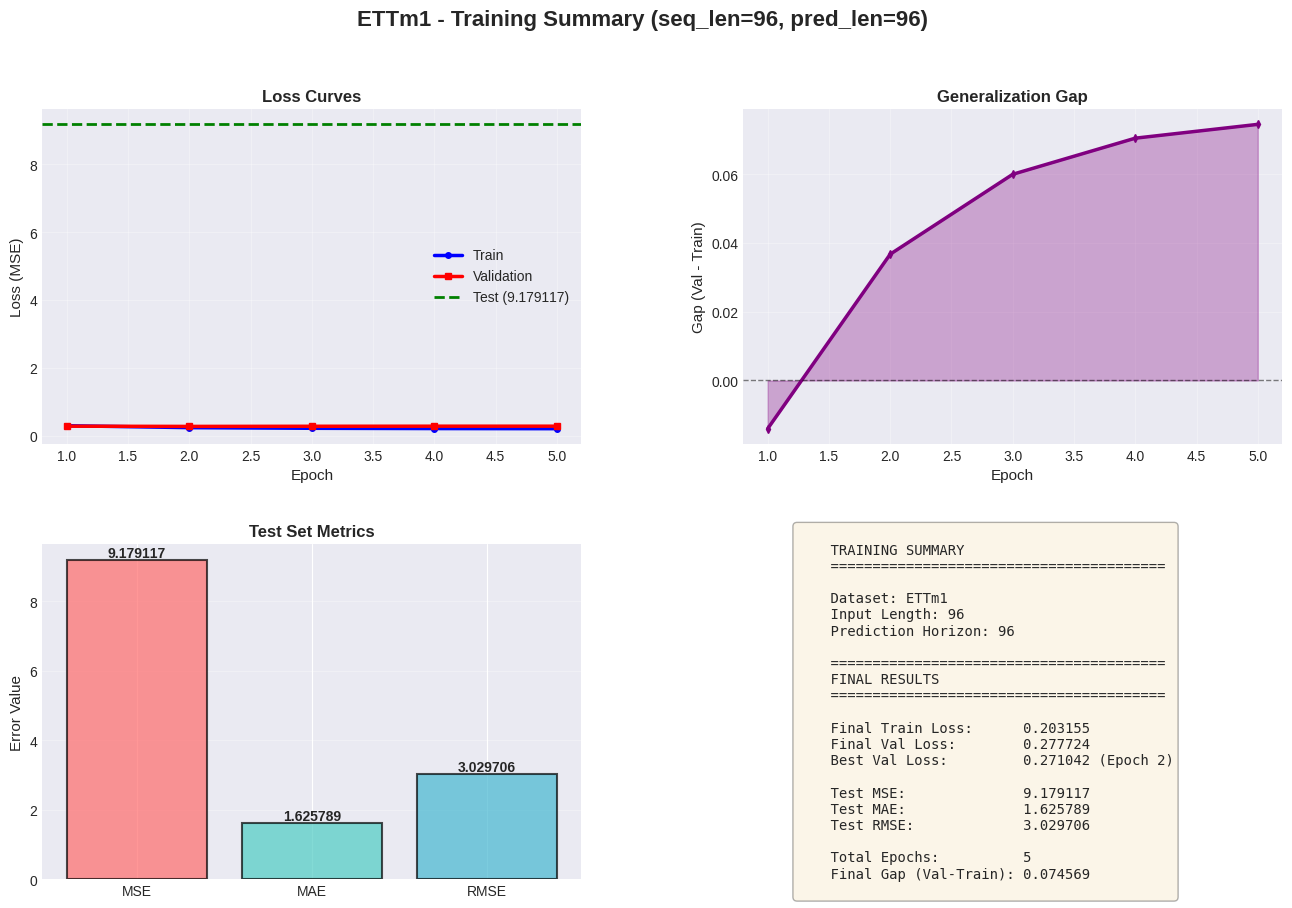

  → Evaluating all splits (train/val/test)...
Evaluating model on all splits...

Train Results:
  MSE: 4.1652827
  MAE: 1.1564338
  RMSE: 2.0409024
  MAPE: 1518166.2500000
  MSPE: 2414107969978368.0000000

Validation Results:
  MSE: 5.7069688
  MAE: 1.2494777
  RMSE: 2.3889263
  MAPE: 366748.9062500
  MSPE: 717508780752896.0000000

Test Results:
  MSE: 9.1791172
  MAE: 1.6257890
  RMSE: 3.0297058
  MAPE: 365562.7500000
  MSPE: 997530380795904.0000000

❌ Error training ETTm1_96_96: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Experiment 4/6
######################################################################

Training: ETTm1 | seq_len=96 → pred_len=192
Using device: cuda
Initializing data loaders...


Traceback (most recent call last):
  File "/tmp/ipython-input-988559071.py", line 17, in <cell line: 0>
    results = train_single_model(dataset_name, pred_len)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1533522811.py", line 72, in train_single_model
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


Train samples: 48489
Val samples: 6777
Test samples: 13745
Initializing model...
Model parameters: 2,372,967
Starting training...
	Iter: 100, Loss: 0.4428437
	Iter: 200, Loss: 0.4124197
	Iter: 300, Loss: 0.3299783
	Iter: 400, Loss: 0.3333005
	Iter: 500, Loss: 0.2804055
	Iter: 600, Loss: 0.3036689
	Iter: 700, Loss: 0.3041936
	Iter: 800, Loss: 0.3544733
	Iter: 900, Loss: 0.3218718
	Iter: 1000, Loss: 0.3139492
	Iter: 1100, Loss: 0.2927264
	Iter: 1200, Loss: 0.2614604
	Iter: 1300, Loss: 0.2425382
	Iter: 1400, Loss: 0.2353717
	Iter: 1500, Loss: 0.3429881
Epoch: 1 | Time: 95.38s
Train Loss: 0.3402181 | Val Loss: 0.3099405
Validation loss decreased (inf --> 0.309940). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.3886549
	Iter: 200, Loss: 0.3210540
	Iter: 300, Loss: 0.3512029
	Iter: 400, Loss: 0.2788996
	Iter: 500, Loss: 0.2682241
	Iter: 600, Loss: 0.2697429
	Iter: 700, Loss: 0.2680089
	Iter: 800, Loss: 0.2085103
	Iter: 900, Loss: 0.2905360
	Iter: 1000, Loss: 0.2419349

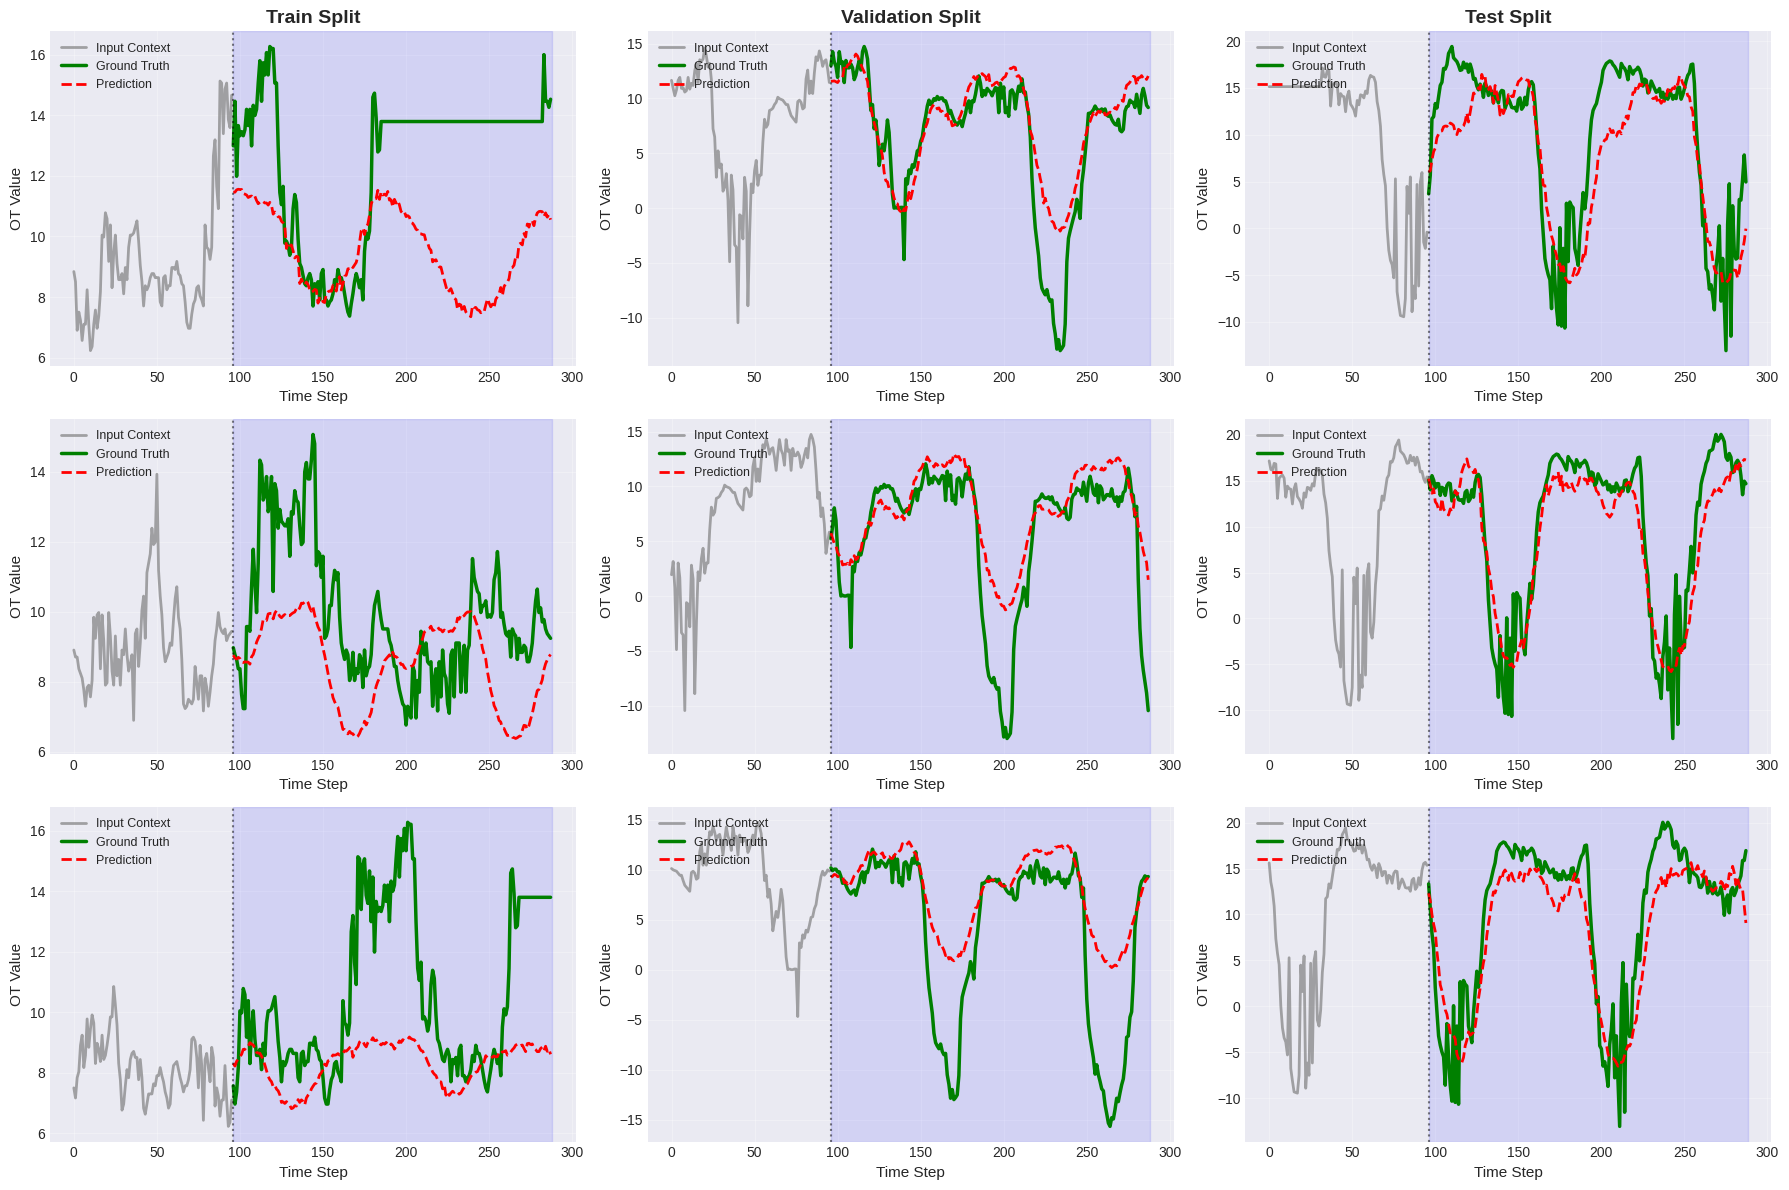

  → Comprehensive training summary...
Comprehensive training summary saved to ./results/ETTm1_96_192_summary.png


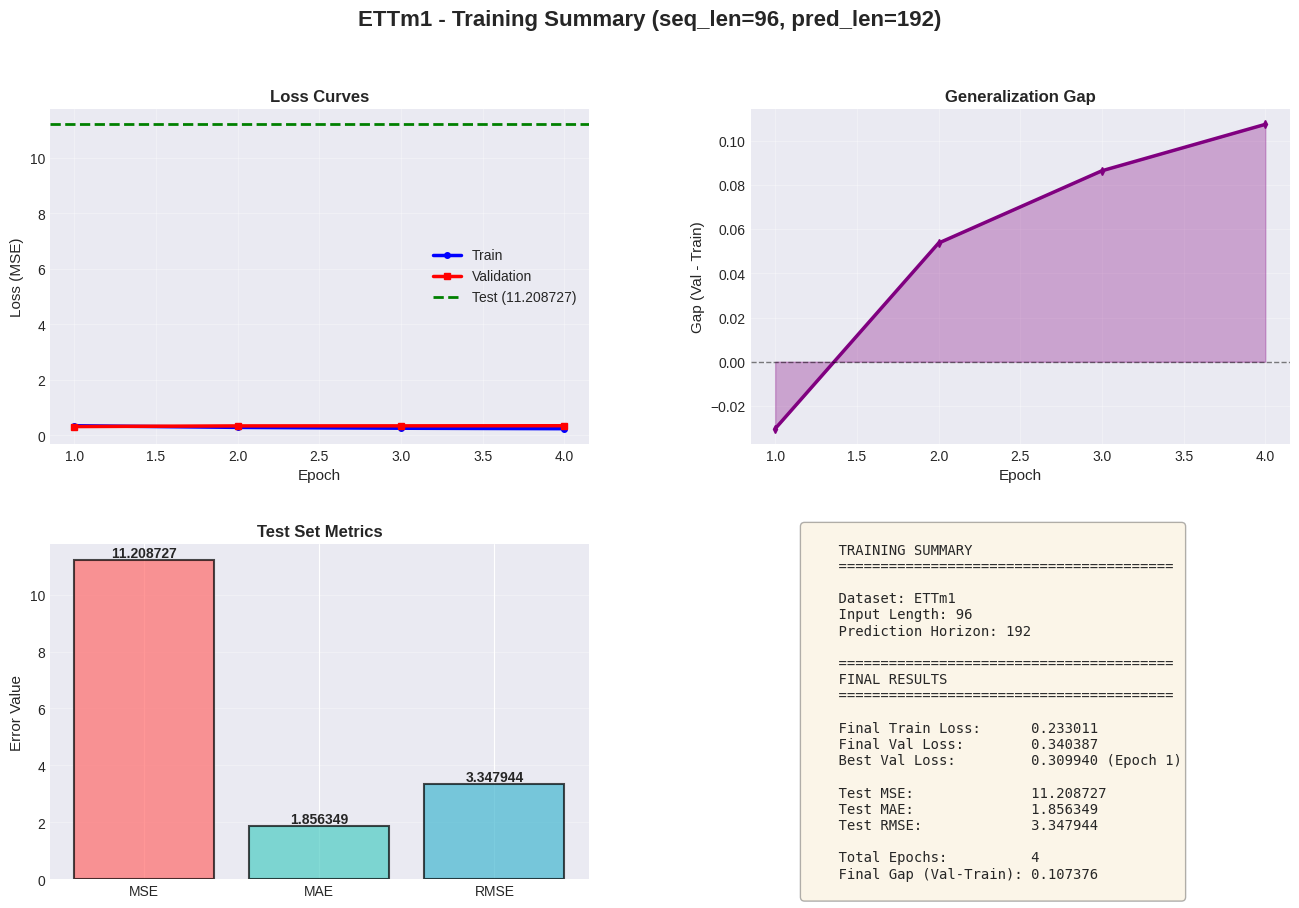

  → Evaluating all splits (train/val/test)...
Evaluating model on all splits...

Train Results:
  MSE: 5.7074680
  MAE: 1.3800313
  RMSE: 2.3890307
  MAPE: 2405650.0000000
  MSPE: 5072371408961536.0000000

Validation Results:
  MSE: 6.8927050
  MAE: 1.3998514
  RMSE: 2.6253963
  MAPE: 372760.1562500
  MSPE: 561712700850176.0000000

Test Results:
  MSE: 11.2087269
  MAE: 1.8563492
  RMSE: 3.3479438
  MAPE: 434457.0937500
  MSPE: 1004396624216064.0000000

❌ Error training ETTm1_96_192: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Experiment 5/6
######################################################################

Training: ETTm1 | seq_len=96 → pred_len=336
Using device: cuda
Initializing data loaders...


Traceback (most recent call last):
  File "/tmp/ipython-input-988559071.py", line 17, in <cell line: 0>
    results = train_single_model(dataset_name, pred_len)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1533522811.py", line 72, in train_single_model
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


Train samples: 48345
Val samples: 6633
Test samples: 13601
Initializing model...
Model parameters: 2,386,935
Starting training...
	Iter: 100, Loss: 0.4602466
	Iter: 200, Loss: 0.4099774
	Iter: 300, Loss: 0.3392356
	Iter: 400, Loss: 0.3802383
	Iter: 500, Loss: 0.4503845
	Iter: 600, Loss: 0.3335631
	Iter: 700, Loss: 0.2795012
	Iter: 800, Loss: 0.4770364
	Iter: 900, Loss: 0.4474469
	Iter: 1000, Loss: 0.3083722
	Iter: 1100, Loss: 0.5177317
	Iter: 1200, Loss: 0.3617567
	Iter: 1300, Loss: 0.3755296
	Iter: 1400, Loss: 0.3642616
	Iter: 1500, Loss: 0.3183964
Epoch: 1 | Time: 158.55s
Train Loss: 0.3983013 | Val Loss: 0.3775588
Validation loss decreased (inf --> 0.377559). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.2935799
	Iter: 200, Loss: 0.3913160
	Iter: 300, Loss: 0.3791207
	Iter: 400, Loss: 0.3514669
	Iter: 500, Loss: 0.3766496
	Iter: 600, Loss: 0.2655578
	Iter: 700, Loss: 0.3815716
	Iter: 800, Loss: 0.3227600
	Iter: 900, Loss: 0.3671319
	Iter: 1000, Loss: 0.326855

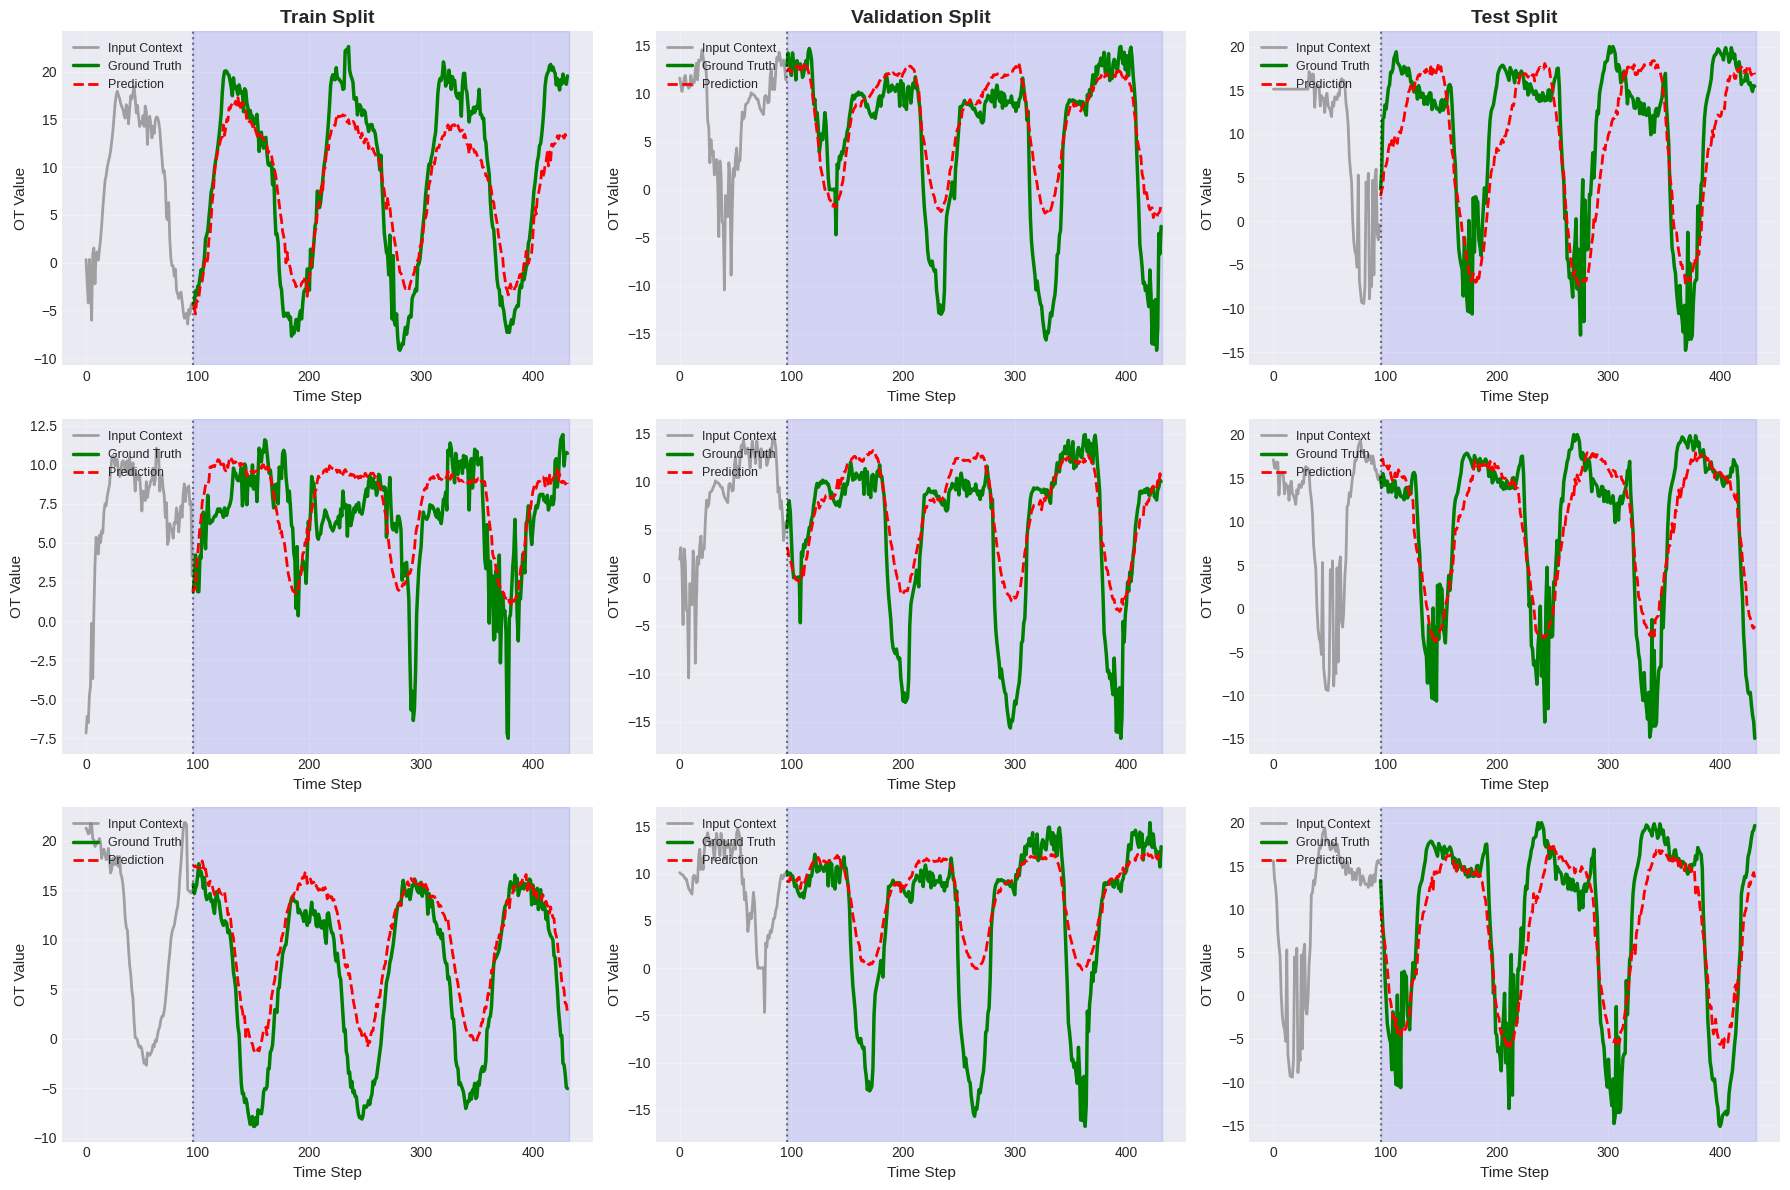

  → Comprehensive training summary...
Comprehensive training summary saved to ./results/ETTm1_96_336_summary.png


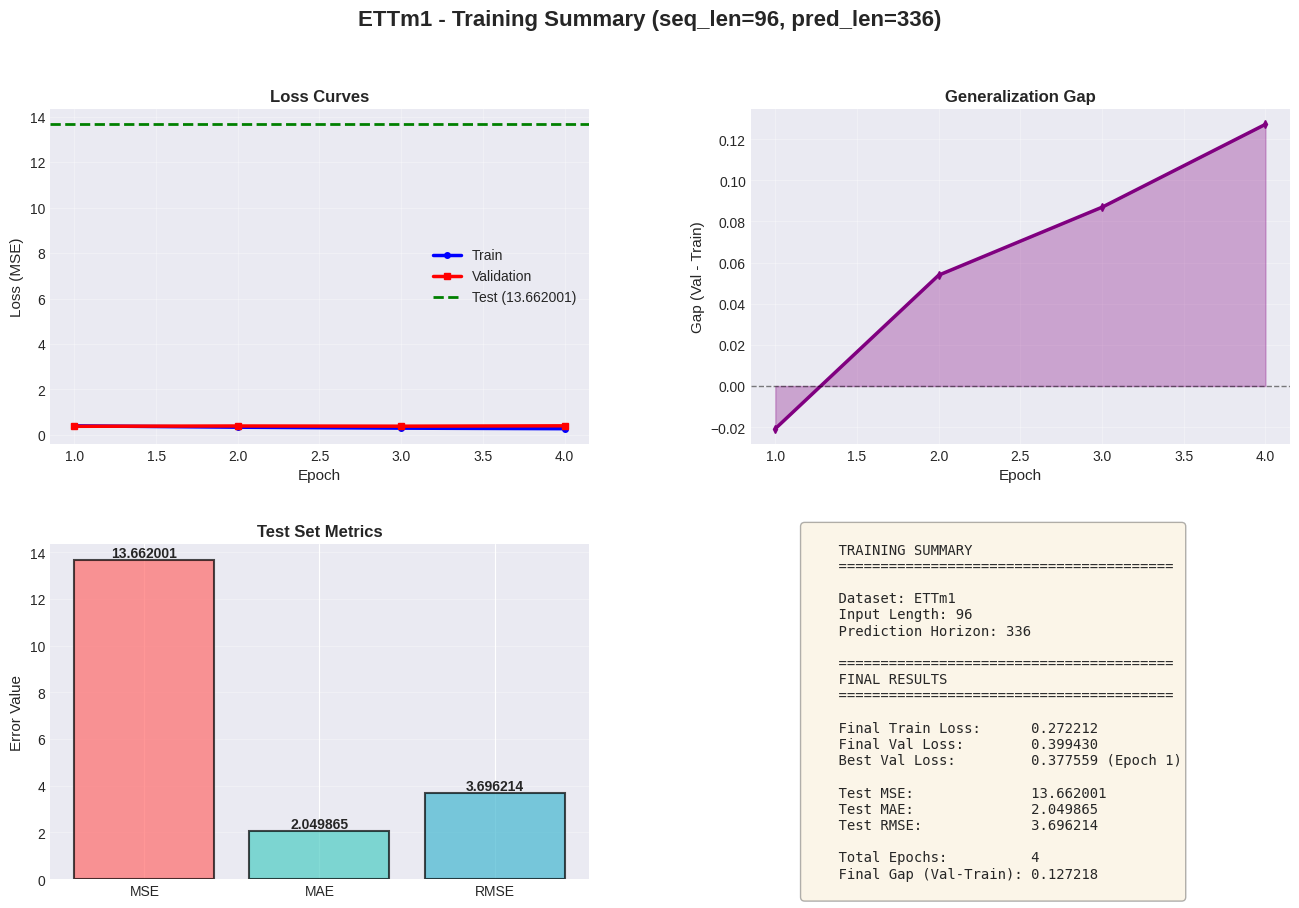

  → Evaluating all splits (train/val/test)...
Evaluating model on all splits...

Train Results:
  MSE: 6.5114546
  MAE: 1.4990617
  RMSE: 2.5517552
  MAPE: 3263349.0000000
  MSPE: 8024664819367936.0000000

Validation Results:
  MSE: 9.0982752
  MAE: 1.5819808
  RMSE: 3.0163348
  MAPE: 447867.4687500
  MSPE: 907977963864064.0000000

Test Results:
  MSE: 13.6620007
  MAE: 2.0498650
  RMSE: 3.6962144
  MAPE: 460548.0625000
  MSPE: 1048715116675072.0000000

❌ Error training ETTm1_96_336: unsupported format string passed to numpy.ndarray.__format__

######################################################################
# Experiment 6/6
######################################################################

Training: ETTm1 | seq_len=96 → pred_len=720
Using device: cuda
Initializing data loaders...


Traceback (most recent call last):
  File "/tmp/ipython-input-988559071.py", line 17, in <cell line: 0>
    results = train_single_model(dataset_name, pred_len)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1533522811.py", line 72, in train_single_model
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


Train samples: 47961
Val samples: 6249
Test samples: 13217
Initializing model...
Model parameters: 2,424,183
Starting training...
	Iter: 100, Loss: 0.5257568
	Iter: 200, Loss: 0.5996540
	Iter: 300, Loss: 0.5186989
	Iter: 400, Loss: 0.5534770
	Iter: 500, Loss: 0.5913173
	Iter: 600, Loss: 0.4404737
	Iter: 700, Loss: 0.5156784
	Iter: 800, Loss: 0.4821579
	Iter: 900, Loss: 0.4294207
	Iter: 1000, Loss: 0.5264501
	Iter: 1100, Loss: 0.5583418
	Iter: 1200, Loss: 0.4056775
	Iter: 1300, Loss: 0.4622607
	Iter: 1400, Loss: 0.4684499
Epoch: 1 | Time: 353.14s
Train Loss: 0.5068174 | Val Loss: 0.4265427
Validation loss decreased (inf --> 0.426543). Saving model ...
Updating learning rate to 0.0001
	Iter: 100, Loss: 0.4472611
	Iter: 200, Loss: 0.4997867
	Iter: 300, Loss: 0.4790545
	Iter: 400, Loss: 0.4320694
	Iter: 500, Loss: 0.4267970
	Iter: 600, Loss: 0.4707672
	Iter: 700, Loss: 0.4891253
	Iter: 800, Loss: 0.3442374
	Iter: 900, Loss: 0.5136558
	Iter: 1000, Loss: 0.4732303
	Iter: 1100, Loss: 0.424951

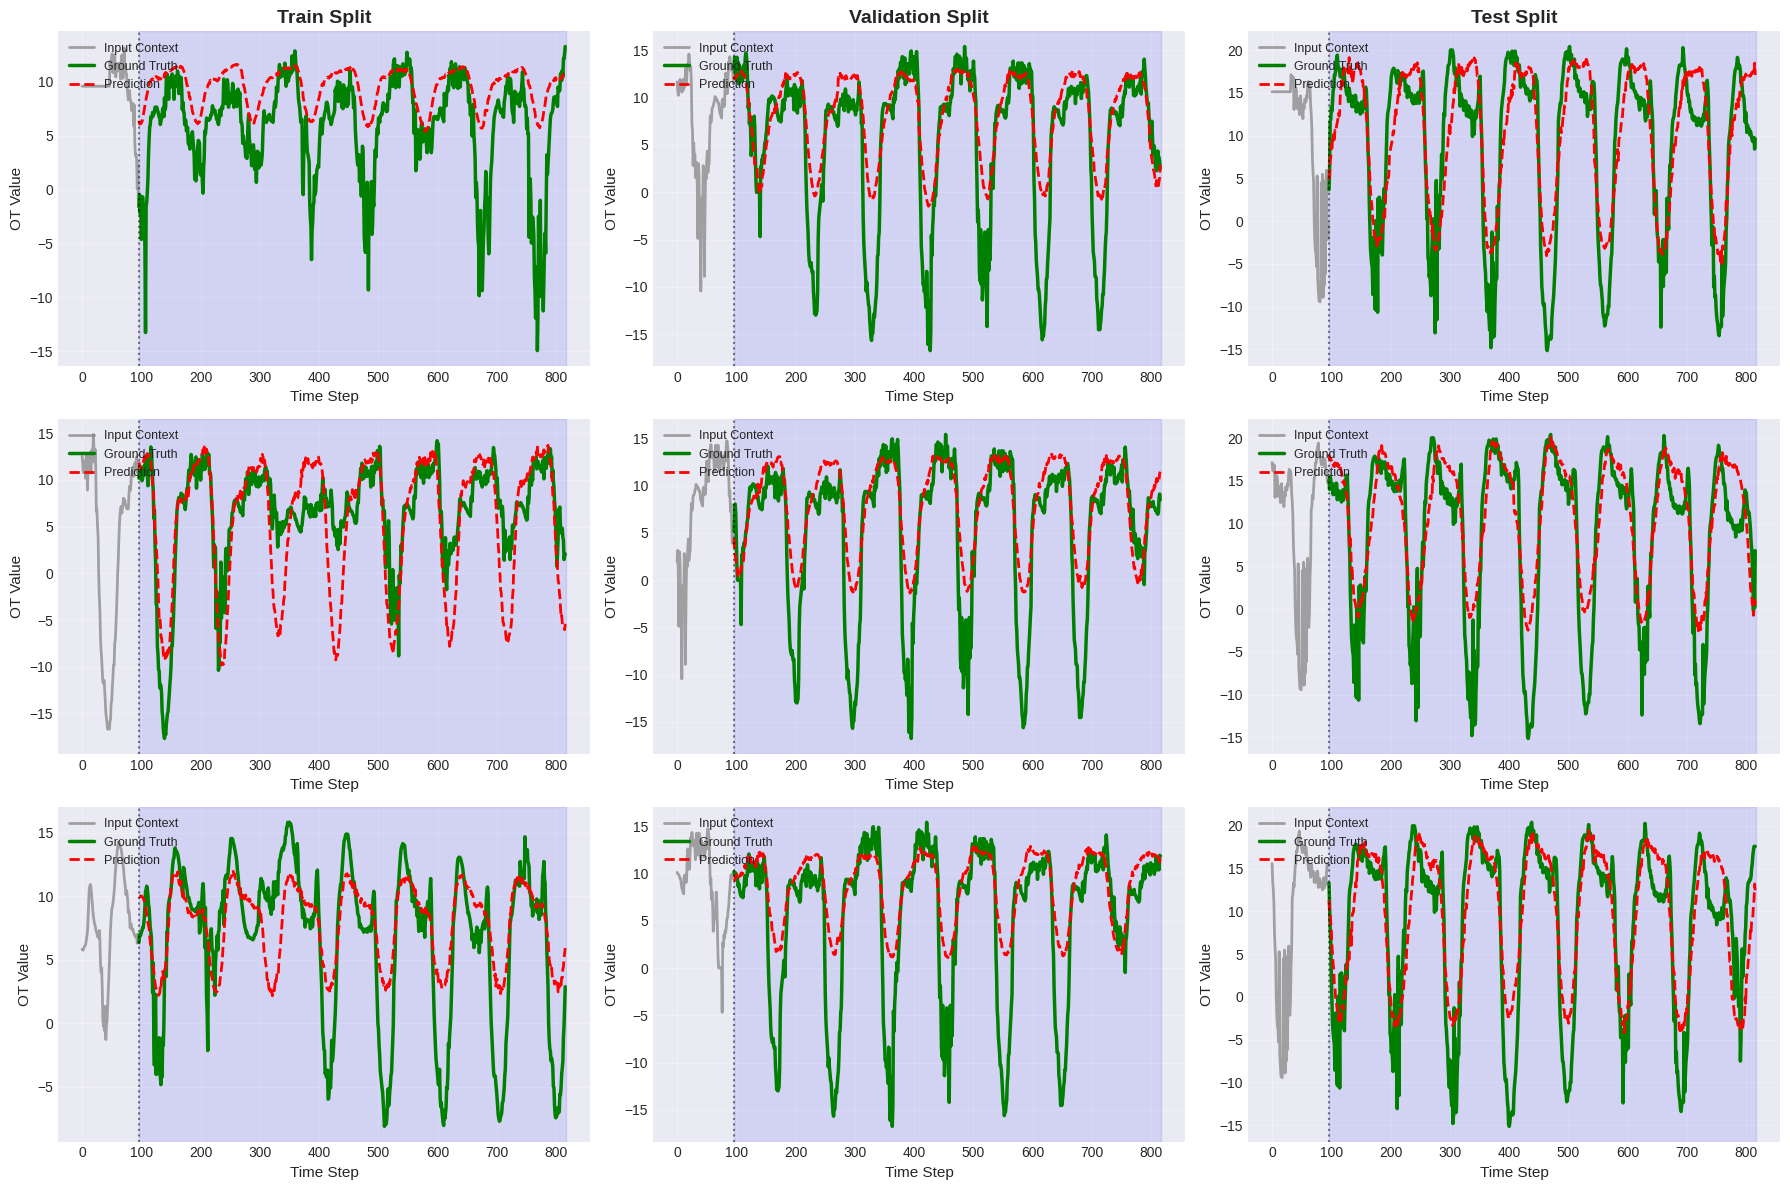

  → Comprehensive training summary...
Comprehensive training summary saved to ./results/ETTm1_96_720_summary.png


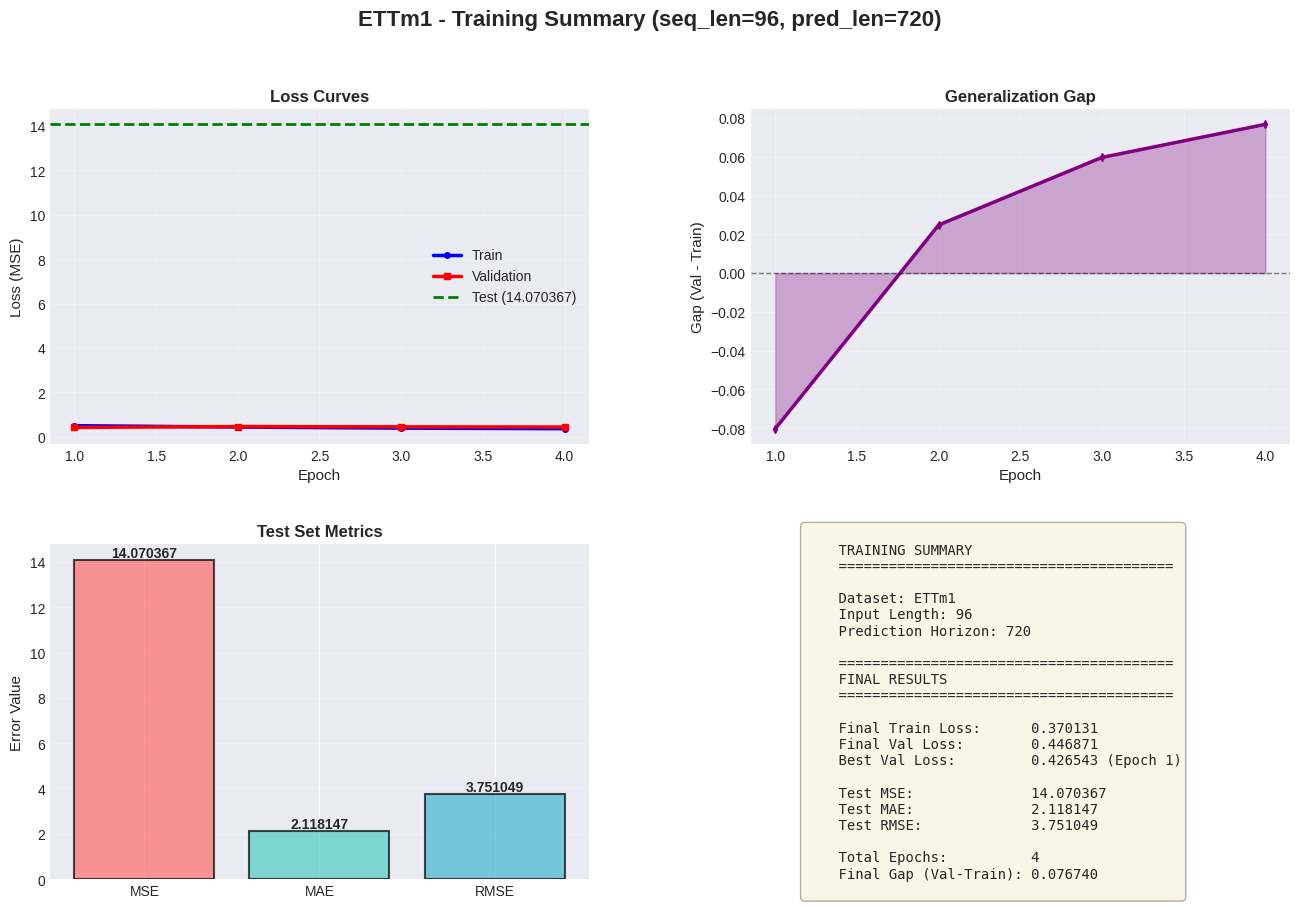

  → Evaluating all splits (train/val/test)...
Evaluating model on all splits...

Train Results:
  MSE: 7.7393231
  MAE: 1.6620736
  RMSE: 2.7819638
  MAPE: 4267870.0000000
  MSPE: 11120958819532800.0000000

Validation Results:
  MSE: 10.7182131
  MAE: 1.7249624
  RMSE: 3.2738683
  MAPE: 528564.8750000
  MSPE: 688852020756480.0000000

Test Results:
  MSE: 14.0703669
  MAE: 2.1181469
  RMSE: 3.7510488
  MAPE: 507398.8437500
  MSPE: 972699698462720.0000000

❌ Error training ETTm1_96_720: unsupported format string passed to numpy.ndarray.__format__

✓ ALL TRAINING COMPLETED!


Traceback (most recent call last):
  File "/tmp/ipython-input-988559071.py", line 17, in <cell line: 0>
    results = train_single_model(dataset_name, pred_len)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1533522811.py", line 72, in train_single_model
    all_split_results = evaluate_and_save_results(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/timesnet-ett/src/evaluate.py", line 184, in evaluate_and_save_results
    f.write(f'  {k}: {v:.7f}\n')
                     ^^^^^^^
TypeError: unsupported format string passed to numpy.ndarray.__format__


In [6]:
# Store all results
all_results = []

# Train all combinations
total_experiments = len(DATASETS) * len(PRED_LENS)
current_experiment = 0

for dataset_name in DATASETS:
    for pred_len in PRED_LENS:
        current_experiment += 1

        print(f"\n{'#'*70}")
        print(f"# Experiment {current_experiment}/{total_experiments}")
        print(f"{'#'*70}")

        try:
            results = train_single_model(dataset_name, pred_len)
            all_results.append(results)

        except Exception as e:
            print(f"\n❌ Error training {dataset_name}_{SEQ_LEN}_{pred_len}: {e}")
            import traceback
            traceback.print_exc()
            continue

print("\n" + "="*70)
print("✓ ALL TRAINING COMPLETED!")
print("="*70)

## Save Results

In [ ]:
# Convert to DataFrame for easy analysis
results_df = pd.DataFrame([{
    'dataset': r['dataset'],
    'seq_len': r['seq_len'],
    'pred_len': r['pred_len'],
    'd_model': r['d_model'],
    'd_ff': r['d_ff'],
    'train_mse': r['train_mse'],
    'train_mae': r['train_mae'],
    'val_mse': r['val_mse'],
    'val_mae': r['val_mae'],
    'test_mse': r['test_mse'],
    'test_mae': r['test_mae'],
    'test_rmse': r['test_rmse'],
    'final_epoch': r['final_epoch']
} for r in all_results])

# Save to CSV
csv_path = f'{RESULTS_DIR}/all_results.csv'
results_df.to_csv(csv_path, index=False)
print(f"✓ Results saved to {csv_path}")

# Save detailed results (with training curves) to JSON
json_path = f'{RESULTS_DIR}/all_results_detailed.json'
with open(json_path, 'w') as f:
    json.dump(all_results, f, indent=2)
print(f"✓ Detailed results saved to {json_path}")

# Display summary
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
display(results_df)

## Results Analysis

### Results by Dataset

In [ ]:
# Group by dataset
for dataset in DATASETS:
    print(f"\n{'='*60}")
    print(f"{dataset} Results")
    print(f"{'='*60}")

    dataset_results = results_df[results_df['dataset'] == dataset]
    display(dataset_results[['pred_len', 'train_mse', 'val_mse', 'test_mse', 'test_mae', 'test_rmse', 'final_epoch']])

### Visualizations

In [ ]:
# Plot MSE vs Prediction Horizon for each dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, dataset in enumerate(DATASETS):
    ax = axes[idx]
    dataset_results = results_df[results_df['dataset'] == dataset].sort_values('pred_len')

    ax.plot(dataset_results['pred_len'], dataset_results['test_mse'],
            marker='o', linewidth=2, markersize=8, label='MSE')
    ax.plot(dataset_results['pred_len'], dataset_results['test_mae'],
            marker='s', linewidth=2, markersize=8, label='MAE')

    ax.set_xlabel('Prediction Horizon', fontsize=12)
    ax.set_ylabel('Error', fontsize=12)
    ax.set_title(f'{dataset} - Error vs Prediction Horizon', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/error_vs_horizon.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to {RESULTS_DIR}/error_vs_horizon.png")

In [ ]:
# Heatmap of MSE across datasets and horizons
pivot_mse = results_df.pivot(index='dataset', columns='pred_len', values='test_mse')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_mse, annot=True, fmt='.4f', cmap='YlOrRd',
            cbar_kws={'label': 'Test MSE'}, linewidths=0.5)
plt.title('Test MSE: Dataset vs Prediction Horizon', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('Dataset', fontsize=12)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/mse_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Heatmap saved to {RESULTS_DIR}/mse_heatmap.png")

In [ ]:
# Heatmap of MAE across datasets and horizons
pivot_mae = results_df.pivot(index='dataset', columns='pred_len', values='test_mae')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_mae, annot=True, fmt='.4f', cmap='YlGnBu',
            cbar_kws={'label': 'Test MAE'}, linewidths=0.5)
plt.title('Test MAE: Dataset vs Prediction Horizon', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction Horizon', fontsize=12)
plt.ylabel('Dataset', fontsize=12)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/mae_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Heatmap saved to {RESULTS_DIR}/mae_heatmap.png")

### Statistical Summary

In [ ]:
# Summary statistics
print("="*70)
print("STATISTICAL SUMMARY")
print("="*70)

print("\nOverall Statistics:")
print(results_df[['test_mse', 'test_mae', 'test_rmse']].describe())

print("\nBest Results (by MSE):")
best_mse = results_df.loc[results_df.groupby('dataset')['test_mse'].idxmin()]
display(best_mse[['dataset', 'pred_len', 'test_mse', 'test_mae', 'test_rmse']])

print("\nBest Results (by MAE):")
best_mae = results_df.loc[results_df.groupby('dataset')['test_mae'].idxmin()]
display(best_mae[['dataset', 'pred_len', 'test_mse', 'test_mae', 'test_rmse']])

### Comparison with Paper Results

In [ ]:
# Paper results (from TimesNet paper Table 1)
paper_results = {
    'ETTh1': {
        96: {'mse': 0.384, 'mae': 0.402},
        192: {'mse': 0.436, 'mae': 0.429},
        336: {'mse': 0.491, 'mae': 0.469},
        720: {'mse': 0.521, 'mae': 0.491},
    },
    'ETTm1': {
        96: {'mse': 0.334, 'mae': 0.365},
        192: {'mse': 0.374, 'mae': 0.385},
        336: {'mse': 0.410, 'mae': 0.403},
        720: {'mse': 0.478, 'mae': 0.437},
    }
}

# Compare with our results
print("="*70)
print("COMPARISON WITH PAPER RESULTS")
print("="*70)

for dataset in ['ETTh1', 'ETTm1']:
    if dataset in paper_results:
        print(f"\n{dataset}:")
        print("-" * 60)
        print(f"{'Horizon':>10} {'Paper MSE':>12} {'Our MSE':>12} {'Diff':>10} {'Paper MAE':>12} {'Our MAE':>12} {'Diff':>10}")
        print("-" * 60)

        for horizon in [96, 192, 336, 720]:
            if horizon in paper_results[dataset]:
                paper = paper_results[dataset][horizon]
                our = results_df[(results_df['dataset'] == dataset) & (results_df['pred_len'] == horizon)]

                if not our.empty:
                    our_mse = our['test_mse'].values[0]
                    our_mae = our['test_mae'].values[0]

                    mse_diff = ((our_mse - paper['mse']) / paper['mse']) * 100
                    mae_diff = ((our_mae - paper['mae']) / paper['mae']) * 100

                    print(f"{horizon:>10} {paper['mse']:>12.4f} {our_mse:>12.4f} {mse_diff:>9.2f}% "
                          f"{paper['mae']:>12.4f} {our_mae:>12.4f} {mae_diff:>9.2f}%")

## Export Results Table (LaTeX)

In [ ]:
# Create LaTeX table
latex_table = []
latex_table.append("\\begin{table}[h]")
latex_table.append("\\centering")
latex_table.append("\\caption{TimesNet Results on ETT Datasets}")
latex_table.append("\\begin{tabular}{lcccc}")
latex_table.append("\\hline")
latex_table.append("Dataset & Horizon & MSE & MAE & RMSE \\\\")
latex_table.append("\\hline")

for dataset in DATASETS:
    dataset_results = results_df[results_df['dataset'] == dataset].sort_values('pred_len')
    for _, row in dataset_results.iterrows():
        latex_table.append(f"{row['dataset']} & {row['pred_len']} & "
                          f"{row['test_mse']:.4f} & {row['test_mae']:.4f} & {row['test_rmse']:.4f} \\\\")
    latex_table.append("\\hline")

latex_table.append("\\end{tabular}")
latex_table.append("\\end{table}")

latex_str = "\n".join(latex_table)

# Save to file
latex_path = f'{RESULTS_DIR}/results_table.tex'
with open(latex_path, 'w') as f:
    f.write(latex_str)

print(f"✓ LaTeX table saved to {latex_path}")
print("\nLaTeX Table:")
print(latex_str)

## Summary

✅ **Training Complete!**

**Trained Models:**
- 4 datasets (ETTh1, ETTh2, ETTm1, ETTm2)
- 6 prediction horizons each (24, 48, 96, 192, 336, 720)
- Total: 24 models

**Output Files:**

📊 **Results Data:**
- `results/all_results.csv` - Summary table with train/val/test metrics
- `results/all_results_detailed.json` - Detailed results with training curves

📈 **Visualizations per model (24 × 3 files = 72 plots):**
- `results/{dataset}_{seq_len}_{pred_len}_horizons.png` - Horizon predictions (train/val/test samples)
- `results/{dataset}_{seq_len}_{pred_len}_summary.png` - Comprehensive 4-panel training summary
- `results/{dataset}_{seq_len}_{pred_len}_all_metrics.txt` - All split metrics (train/val/test)

📊 **Aggregate Visualizations:**
- `results/error_vs_horizon.png` - Error vs horizon plots
- `results/mse_heatmap.png` - MSE heatmap
- `results/mae_heatmap.png` - MAE heatmap
- `results/results_table.tex` - LaTeX table

💾 **Model Checkpoints:**
- `checkpoints/{dataset}_{seq_len}_{pred_len}/checkpoint.pth` - Best model weights (24 models)